In [1]:
%pip install pandas
%pip install numpy
%pip install regex
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import sys
import os
import regex


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict

import time
import datetime

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

from numpy import polyfit
from pandas.plotting import autocorrelation_plot

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

# Dependent Variable (API)

<AxesSubplot:xlabel='date', ylabel='SO2'>

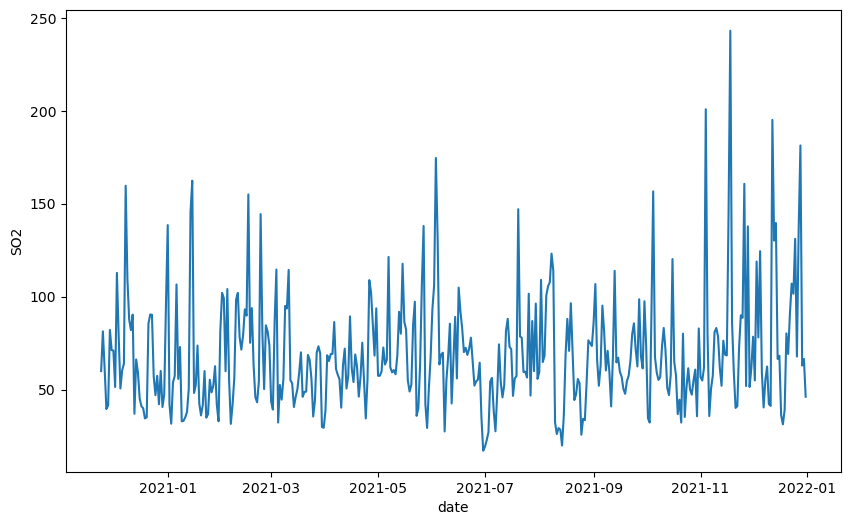

In [3]:
df = pd.read_csv("../../data/Combined_data_for_recreate/cluster/Delhi_SO2.csv")
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df = df[["date", "open_SO2"]].dropna().rename(columns={"open_SO2":"SO2"})
df = df.sort_values("date").reset_index(drop=True)
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="date", y=df["SO2"])

In [4]:
df

date         SO2
0   2020-11-24   59.962500
1   2020-11-25   81.340417
2   2020-11-26   61.284167
3   2020-11-27   39.547917
4   2020-11-28   41.565000
..         ...         ...
398 2021-12-27  135.878333
399 2021-12-28  181.317917
400 2021-12-29   62.972500
401 2021-12-30   66.460417
402 2021-12-31   46.164583

[403 rows x 2 columns]

<AxesSubplot:xlabel='date', ylabel='SO2'>

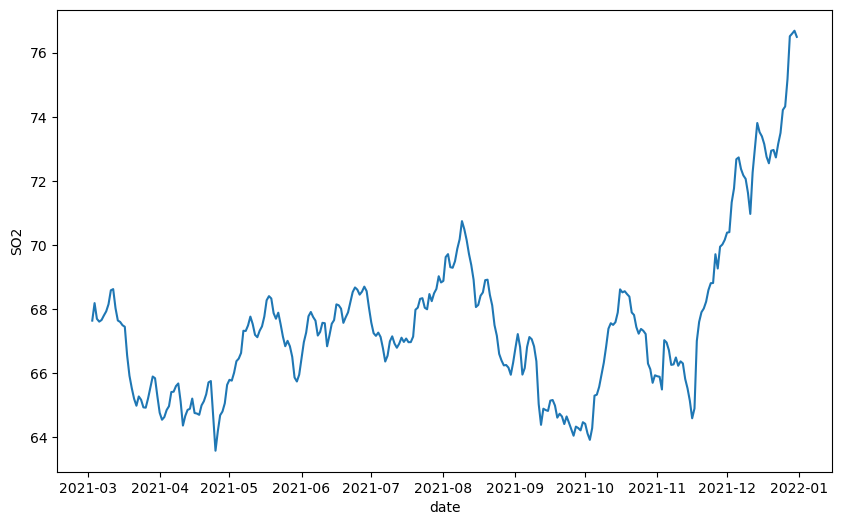

In [5]:
df["SO2"] = df["SO2"].rolling(100).mean()
df = df.dropna().reset_index(drop=True)
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="date", y=df["SO2"])

In [6]:
def adfuller_test(y):
    result=adfuller(y)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")
adfuller_test(df["SO2"])

ADF Test Statistic : -0.4522860476337087
p-value : 0.9009960868733815
#Lags Used : 1
Number of Observations : 302
weak evidence against null hypothesis,indicating it is non-stationary 


Coefficients: [ 4.12284053e-17 -5.51855353e-14  2.99250472e-11 -8.54698832e-09
  1.43064052e-06 -1.50237948e-04  9.89488385e-03 -3.27124522e-01
  6.92312418e+01]


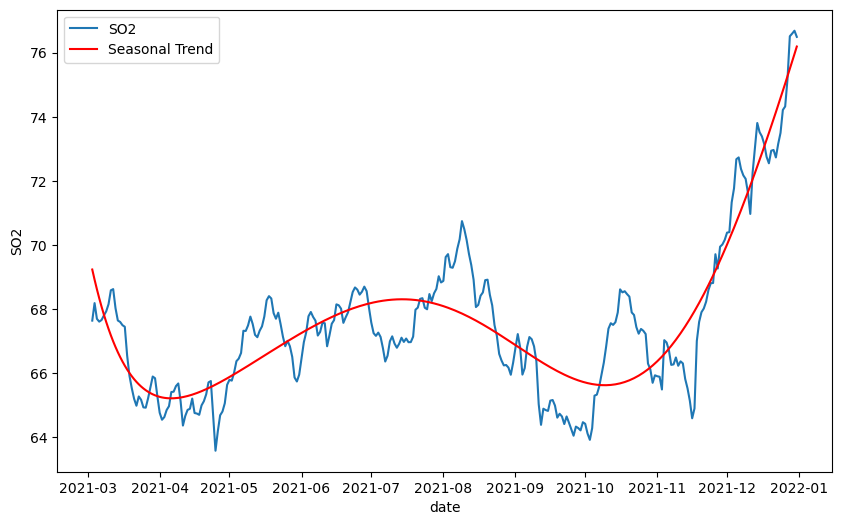

In [7]:
y = df["SO2"]
x = [i%365 for i in range(0, len(y))]
degree = 8
coef = polyfit(x, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(x)):
    value = coef[-1]
    for d in range(degree):
        value += x[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="date", y=y.values, label="SO2")
sns.lineplot(data=df, x="date", y=curve, color='red', label="Seasonal Trend")
plt.ylabel("SO2")
plt.show()

<AxesSubplot:xlabel='date', ylabel='diff'>

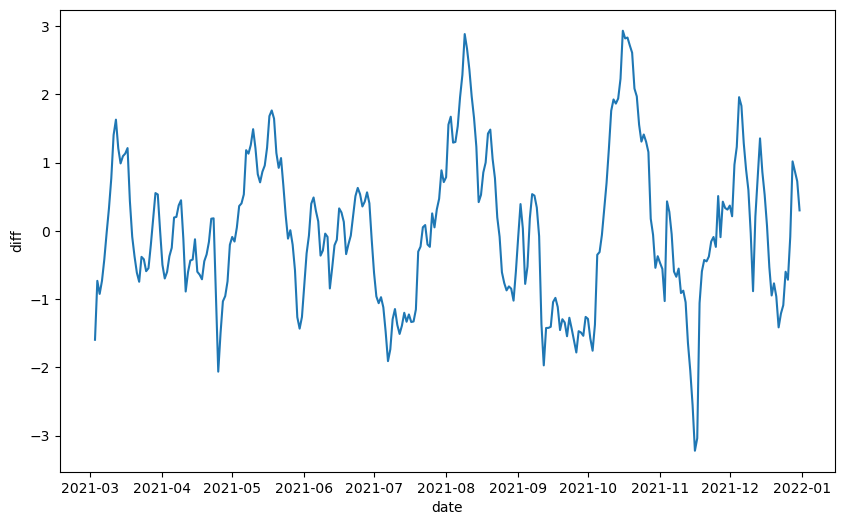

In [8]:
diff = list()
for i in range(len(y)):
	value = y[i] - curve[i]
	diff.append(value)

df["diff"] = diff
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="date", y="diff")

In [9]:
adfuller_test(diff)

ADF Test Statistic : -4.715117934895278
p-value : 7.881869996543707e-05
#Lags Used : 14
Number of Observations : 289
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [10]:
df['First Difference'] = df['diff'] - df['diff'].shift(1)
df['Seasonal First Difference']=df['diff']-df['diff'].shift(15)
df.head()

date        SO2      diff  First Difference  Seasonal First Difference
0 2021-03-03  67.636266 -1.594976               NaN                        NaN
1 2021-03-04  68.182445 -0.731418          0.863558                        NaN
2 2021-03-05  67.692108 -0.923286         -0.191867                        NaN
3 2021-03-06  67.604174 -0.730805          0.192480                        NaN
4 2021-03-07  67.654853 -0.416951          0.313855                        NaN

ADF Test Statistic : -4.299265405473307
p-value : 0.00044551528744952345
#Lags Used : 16
Number of Observations : 272
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<AxesSubplot:xlabel='date', ylabel='Seasonal First Difference'>

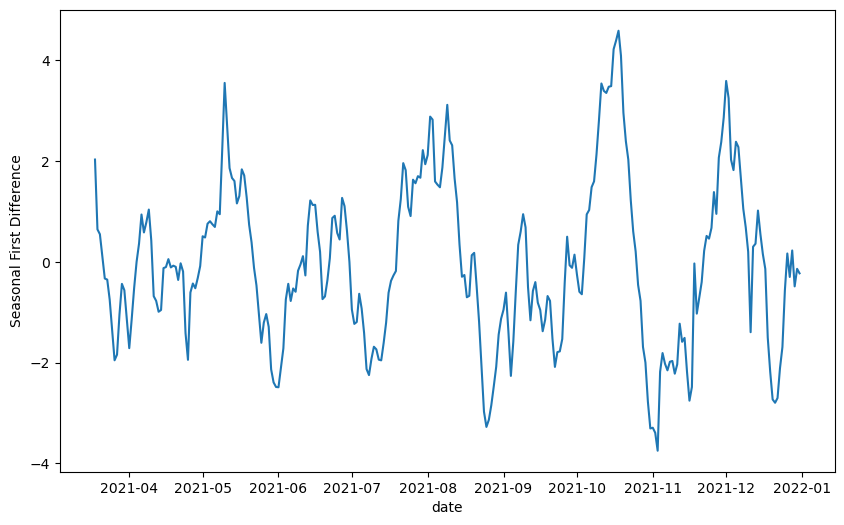

In [11]:
adfuller_test(df['Seasonal First Difference'].dropna())
plt.figure(figsize=(10,6))
sns.lineplot(data = df, x="date", y='Seasonal First Difference')

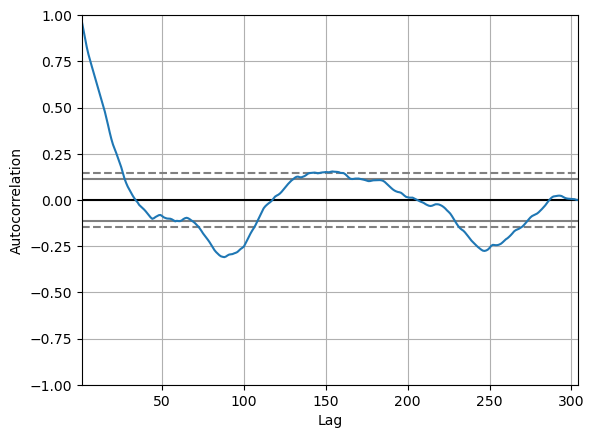

In [12]:
autocorrelation_plot(y)
plt.show()

c:\miniconda\envs\DSCC483\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


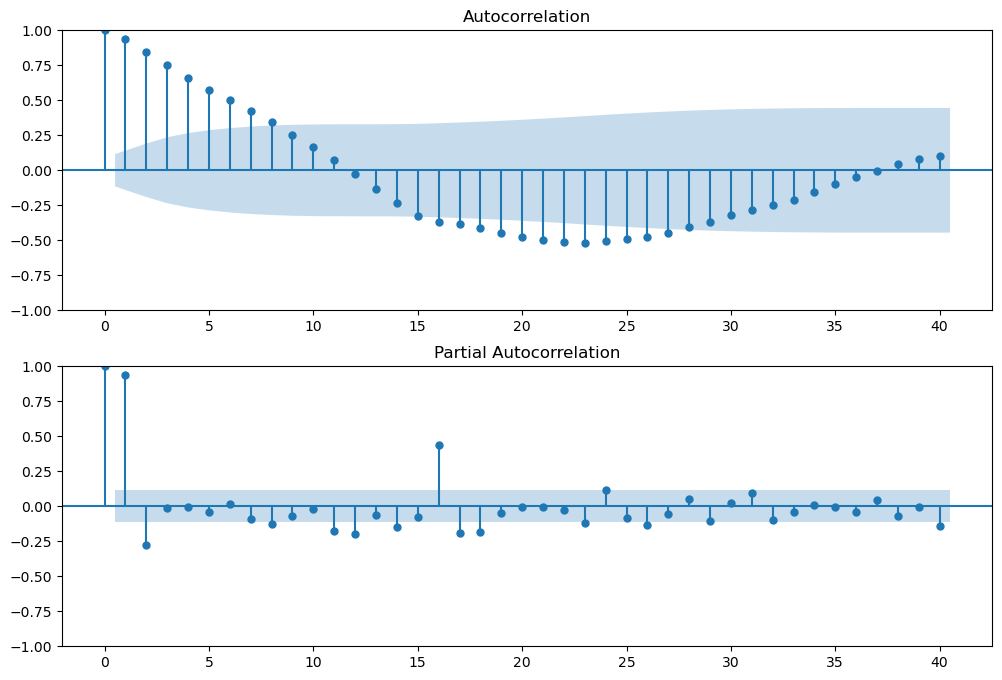

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

# Independent Variable (Stations)

date    open_SO2  sate_SO2  Alipur, Delhi - DPCC  \
0       2018/1/1         NaN    -0.150                 18.65   
1       2018/1/2         NaN     0.108                 23.32   
2       2018/1/3         NaN    -0.110                 14.41   
3       2018/1/4         NaN    -0.006                 15.32   
4       2018/1/5         NaN    -0.210                 15.54   
...          ...         ...       ...                   ...   
1456  2021/12/27  135.878333     0.134                  7.27   
1457  2021/12/28  181.317917     0.012                  7.39   
1458  2021/12/29   62.972500    -1.420                  6.32   
1459  2021/12/30   66.460417    -0.046                  8.35   
1460  2021/12/31   46.164583     1.010                  6.15   

      Anand Vihar, Delhi - DPCC  Ashok Vihar, Delhi - DPCC  \
0                         21.69                  26.793333   
1                         23.63                  15.433333   
2                         20.43                  15.770000   
3                         21.95                  15.006667   
4                         21.69                  11.566667   
...                         ...                        ...   
1456                      27.59                  12.210000   
1457                      24.14                  13.070000   
1458                      21.75                  12.630000   
1459                      16.72                  15.070000   
1460                      21.23                  13.230000   

      Aya Nagar, Delhi - IMD  Bawana, Delhi - DPCC  \
0                   9.107204              9.635006   
1                   6.432204              9.635006   
2                   8.147204              9.635006   
3                   9.157204              9.635006   
4                   6.127204              9.635006   
...                      ...                   ...   
1456               13.543333              3.260000   
1457               13.153333              3.610000   
1458               14.496667              2.390000   
1459               19.376667              3.490000   
1460               17.100000              2.330000   

      Burari Crossing, Delhi - IMD  Chandni Chowk, Delhi - IITM  ...  \
0                          18.6500                         9.52  ...   
1                          23.3200                         5.12  ...   
2                          14.4100                        11.02  ...   
3                          15.3200                        16.82  ...   
4                          15.5400                        14.62  ...   
...                            ...                          ...  ...   
1456                       12.2225                        19.68  ...   
1457                       11.0850                        23.74  ...   
1458                       11.8775                         9.60  ...   
1459                       16.7975                         7.86  ...   
1460                       16.2425                        18.71  ...   

      Pusa, Delhi - DPCC  Pusa, Delhi - IMD  R K Puram, Delhi - DPCC  \
0                 30.310              12.54                    18.65   
1                 19.505              13.13                    23.32   
2                 26.390               8.10                    14.41   
3                 25.810               8.77                    15.32   
4                 22.565              11.44                    15.54   
...                  ...                ...                      ...   
1456               5.860               5.86                    17.92   
1457               5.140               5.14                    15.51   
1458               5.830               5.83                    20.30   
1459               7.300               7.30                    32.74   
1460               6.370               6.37                    35.17   

      Rohini, Delhi - DPCC  Shadipur, Delhi - CPCB  Sirifort, Delhi - CPCB  \
0                 9.635006               

<AxesSubplot:xlabel='date', ylabel='SO2'>

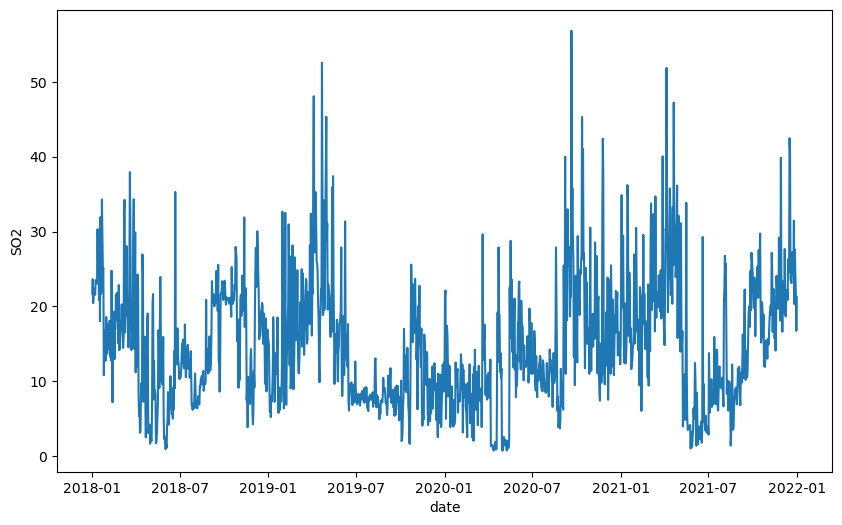

In [14]:
df = pd.read_csv("../../data/Combined_data_for_recreate/cluster/Delhi_SO2.csv")
display(df)
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df = df[["date", "Anand Vihar, Delhi - DPCC"]].dropna().rename(columns={"Anand Vihar, Delhi - DPCC":"SO2"})
df = df.sort_values("date").reset_index(drop=True)
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="date", y=df["SO2"])

In [15]:
df

date    SO2
0    2018-01-01  21.69
1    2018-01-02  23.63
2    2018-01-03  20.43
3    2018-01-04  21.95
4    2018-01-05  21.69
...         ...    ...
1456 2021-12-27  27.59
1457 2021-12-28  24.14
1458 2021-12-29  21.75
1459 2021-12-30  16.72
1460 2021-12-31  21.23

[1461 rows x 2 columns]

<AxesSubplot:xlabel='date', ylabel='SO2'>

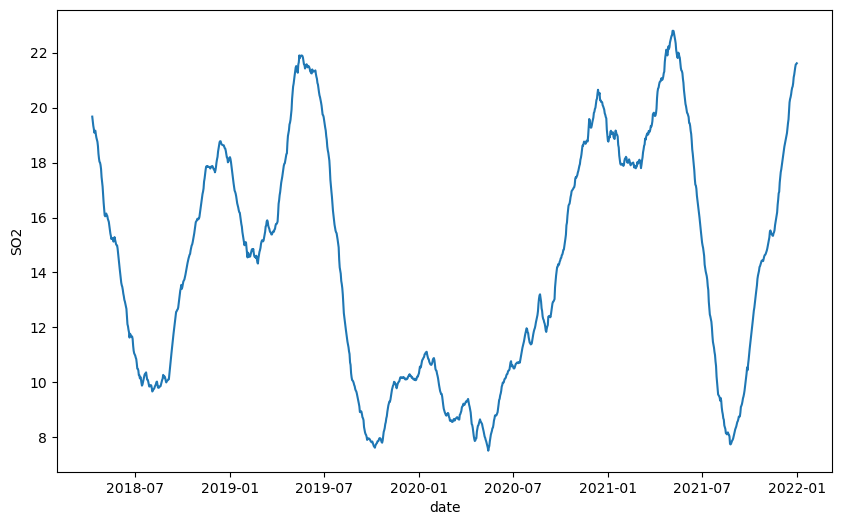

In [16]:
df["SO2"] = df["SO2"].rolling(100).mean()
df = df.dropna().reset_index(drop=True)
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="date", y=df["SO2"])

In [17]:
def adfuller_test(y):
    result=adfuller(y)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")
adfuller_test(df["SO2"])

ADF Test Statistic : -3.279649979848249
p-value : 0.01581299090934509
#Lags Used : 16
Number of Observations : 1345
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


Coefficients: [-2.22378184e-17  2.60799586e-14 -1.08324345e-11  1.69469348e-09
 -3.88376446e-09 -1.76862219e-05  4.09782013e-04  1.35192532e-02
  1.65700003e+01]


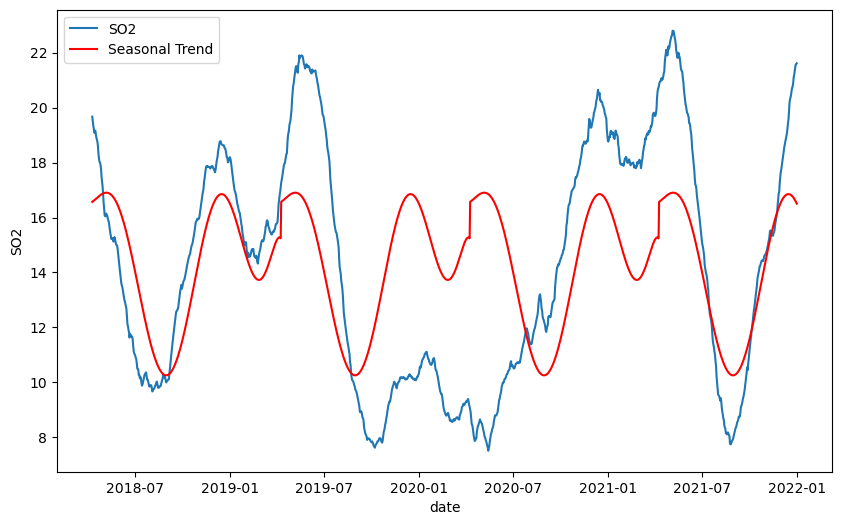

In [18]:
y = df["SO2"]
x = [i%365 for i in range(0, len(y))]
degree = 8
coef = polyfit(x, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(x)):
    value = coef[-1]
    for d in range(degree):
        value += x[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="date", y=y.values, label="SO2")
sns.lineplot(data=df, x="date", y=curve, color='red', label="Seasonal Trend")
plt.ylabel("SO2")
plt.show()

<AxesSubplot:xlabel='date', ylabel='diff'>

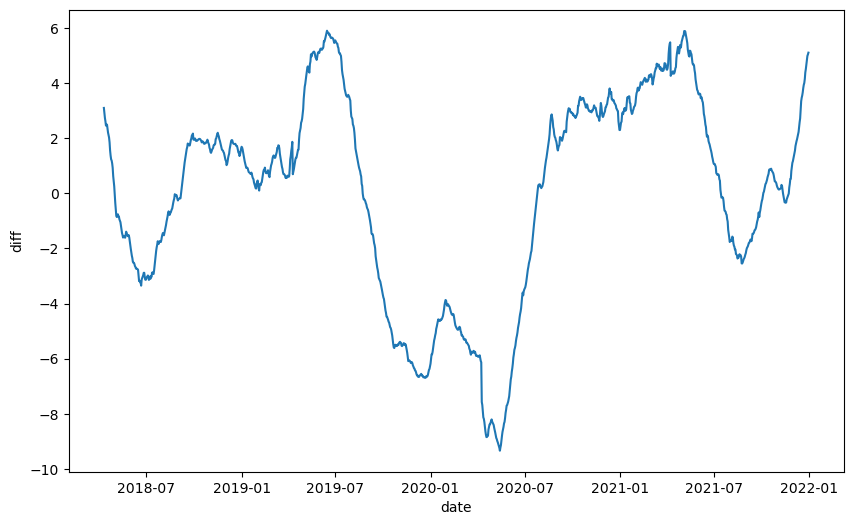

In [19]:
diff = list()
for i in range(len(y)):
	value = y[i] - curve[i]
	diff.append(value)

df["diff"] = diff
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="date", y="diff")

In [20]:
adfuller_test(diff)

ADF Test Statistic : -2.040825273053277
p-value : 0.2689643438819791
#Lags Used : 15
Number of Observations : 1346
weak evidence against null hypothesis,indicating it is non-stationary 


In [21]:
df['First Difference'] = df['diff'] - df['diff'].shift(1)
df['Seasonal First Difference']=df['diff']-df['diff'].shift(15)
df.head()

date      SO2      diff  First Difference  Seasonal First Difference
0 2018-04-10  19.6731  3.103100               NaN                        NaN
1 2018-04-11  19.4897  2.905788         -0.197311                        NaN
2 2018-04-12  19.3388  2.740264         -0.165525                        NaN
3 2018-04-13  19.2321  2.618331         -0.121932                        NaN
4 2018-04-14  19.0900  2.460497         -0.157834                        NaN

ADF Test Statistic : -3.872074958154008
p-value : 0.002250247260576896
#Lags Used : 22
Number of Observations : 1324
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<AxesSubplot:xlabel='date', ylabel='Seasonal First Difference'>

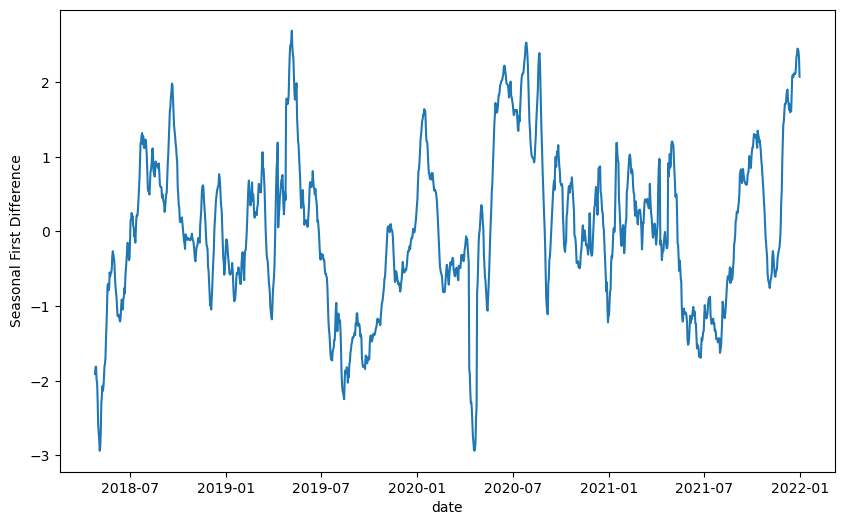

In [22]:
adfuller_test(df['Seasonal First Difference'].dropna())
plt.figure(figsize=(10,6))
sns.lineplot(data = df, x="date", y='Seasonal First Difference')

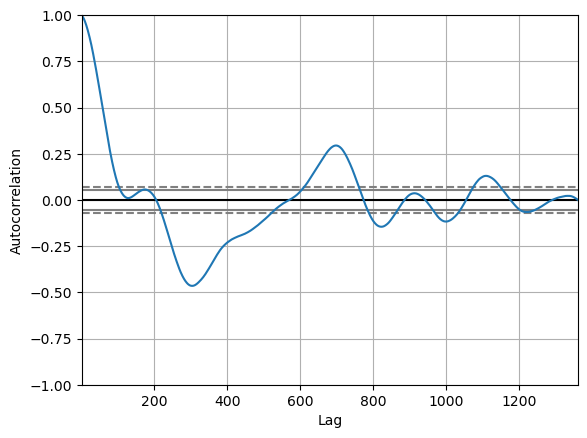

In [23]:
autocorrelation_plot(y)
plt.show()

c:\miniconda\envs\DSCC483\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


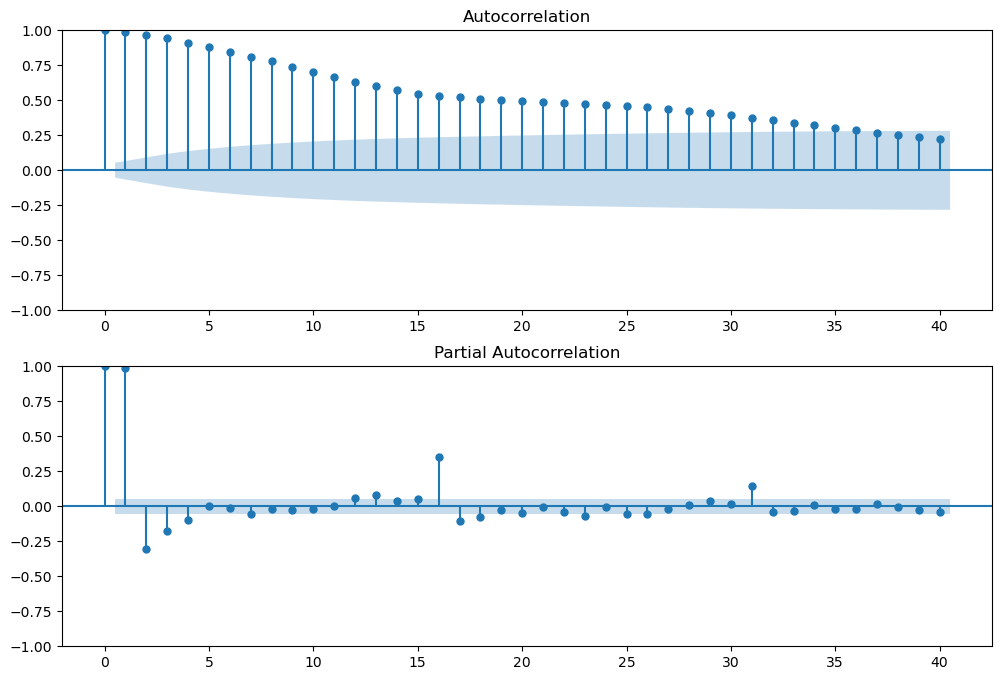

In [24]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax2)